In [1]:
import h5py
import time, copy, sys, os
import scipy.stats as ss
import numpy as np
import scipy
from scipy.special import logsumexp
from scipy.signal import savgol_filter

%matplotlib inline
import seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from importlib import reload

In [2]:
import sys
path = "../"
sys.path.append(path)

import functions, models, gnobs, analysis_data
import read_pe_samples
from conversions import *

In [3]:
params = {'font.family': 'serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large','font.size':15}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 300

In [4]:
choice = ''
fname = path + 'results/' + 'o1o2o3a_UinComov_ng11_AD0.1_ifar5.0_pv2_ak1.hdf5'

directory = path + 'plots/' + fname.split('/')[-1][:-5]
print (directory)

../plots/o1o2o3a_UinComov_ng11_AD0.1_ifar5.0_pv2_ak1


In [5]:
if not os.path.exists(directory):
    os.makedirs(directory)
elif choice == 'y':
    pass
else:
    print ('Directory already exist! Proceed ?')
    choice = input().lower()

In [6]:
results = functions.read_results(fname)

In [7]:
nobs = results['args_sampler']['nobs']
rate = results['posteriors']['rate']
likelihood = results['posteriors']['log_lkl']
post_pdfs_mch = results['ppd']['post_pdf_mch']
post_pdfs_sz = results['ppd']['post_pdf_sz']
post_pdfs_q = results['ppd']['post_pdf_q']
post_pdfs_mass = results['ppd']['post_pdf_mass']
ppd_mch = results['ppd']['ppd_mch']
ppd_q = results['ppd']['ppd_q']
ppd_s1z = results['ppd']['ppd_s1z']
ppd_s2z = results['ppd']['ppd_s2z']
ppd_chieff = results['ppd']['ppd_chieff']

mass_ax = results['args_ppd']['mass_ax']
mch_ax = results['args_ppd']['mch_ax']
q_ax = results['args_ppd']['q_ax']
sz_ax = results['args_ppd']['sz_ax']
ppd_m1, ppd_m2 = qmch_to_m1m2(ppd_mch, ppd_q)
ppd_M = ppd_m1 + ppd_m2

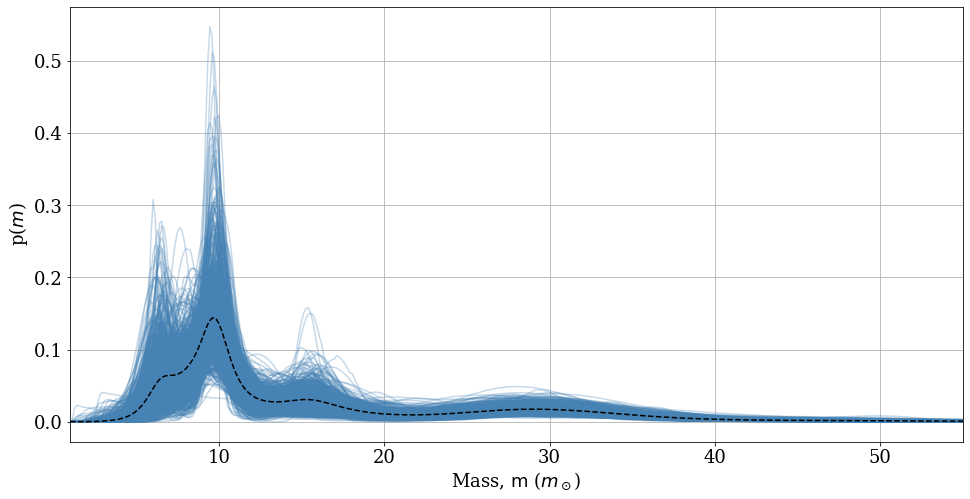

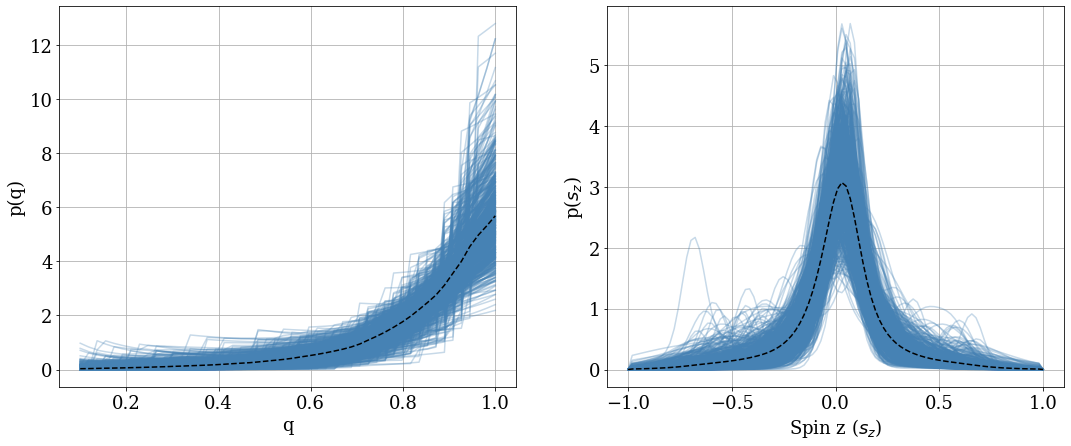

In [8]:
fig = plt.figure(figsize = (16.0, 8.0))
for ii, pdf in enumerate(post_pdfs_mass):
    plt.plot(mass_ax, pdf, color = 'steelblue', alpha = 0.3)

plt.plot(mass_ax, np.mean(post_pdfs_mass, axis = 0), color = 'black', linestyle = '--')
plt.xlim(1., 55.)
plt.grid()
plt.xlabel('Mass, $\mathrm{m}$ ($m_\odot$)')
plt.ylabel('p($m$)')
plt.savefig(directory + '/sphagetti_mass.jpg', dpi = dpi, bbox_inches = 'tight')

fig = plt.figure(figsize = (18.0, 7.0))
plt.subplot(1, 2, 1)
for ii, pdf in enumerate(post_pdfs_q):
    plt.plot(q_ax, pdf, color = 'steelblue', alpha = 0.3)

plt.plot(q_ax, np.mean(post_pdfs_q, axis = 0), color = 'black', linestyle = '--')
plt.grid()
plt.xlabel('q')
plt.ylabel('p(q)')
plt.subplot(1, 2, 2)
for ii, pdf in enumerate(post_pdfs_sz):
    plt.plot(sz_ax, pdf, color = 'steelblue', alpha = 0.3)

plt.plot(sz_ax, np.mean(post_pdfs_sz, axis = 0), color = 'black', linestyle = '--')
plt.grid()
plt.xlabel('Spin z ($s_z$)')
plt.ylabel('p($s_z$)')

plt.savefig(directory + '/sphagetti_q_sz.jpg', dpi = dpi, bbox_inches = 'tight')

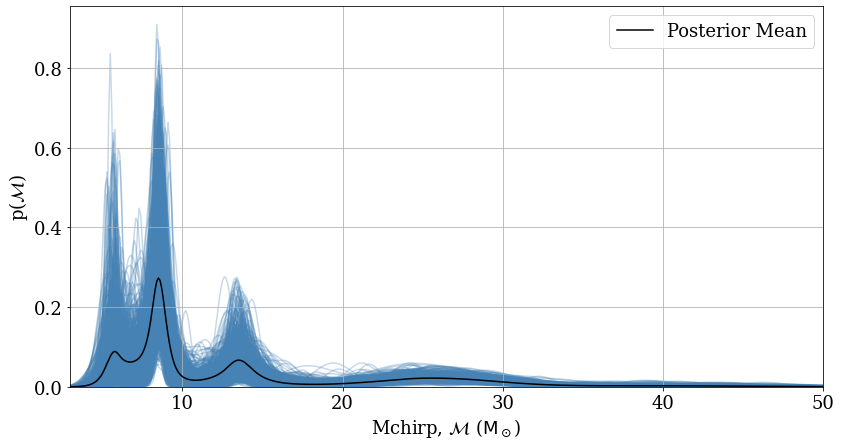

In [9]:
fig = plt.figure(figsize = (9.0 * 1.5, 7.0))
for ii, pdf in enumerate(post_pdfs_mch):
    plt.plot(mch_ax, pdf, color = 'steelblue', alpha = 0.3, zorder = 1)

plt.plot(mch_ax, np.mean(post_pdfs_mch, axis = 0), color = 'black', label = 'Posterior Mean')
#plt.plot(mch_ax, ll_varobs_mean, color = 'black', linestyle = '--', label = 'Observed $\mathcal{M}$')

plt.xlabel('Mchirp, $\mathcal{M}$ ($\mathrm{M}_\odot$)')
plt.ylabel('p($\mathcal{M}$)')
plt.legend(loc = 'upper right')
plt.xlim(3.,50.)
plt.ylim(0, None)
plt.grid()
plt.savefig(directory + '/sphagetti_mchirp.jpg', dpi = dpi, bbox_inches = 'tight')

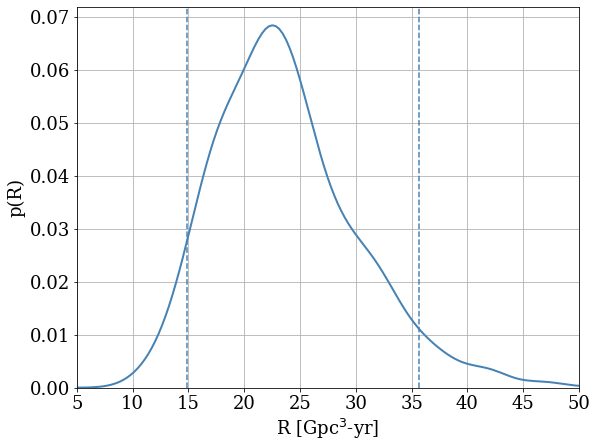

In [10]:
fig = plt.figure(figsize = (9.0, 7.0))
seaborn.kdeplot(rate, color = 'steelblue', linewidth=2.)
plt.axvline(x = np.percentile(rate, 5.), linestyle = '--', color = 'steelblue')
plt.axvline(x = np.percentile(rate, 95.), linestyle = '--', color = 'steelblue')
plt.xlabel('R [Gpc$^3$-yr]')
plt.ylabel('p(R)')
plt.grid()
plt.xlim(5., 50.)
plt.savefig(directory + '/rate_posterior.jpg', dpi = dpi, bbox_inches = 'tight')

In [11]:
nperkde = 10
print (len(ppd_M[::nperkde]))
ncontour = 11

75


In [12]:
ppdmch = ppd_mch.flatten()
ppdsz = ppd_s1z.flatten()
ppdq = ppd_q.flatten()
mchax = np.linspace(5., 55., 51)
p5_mch_sz, p25_mch_sz, p50_mch_sz = [], [], []
p75_mch_sz, p95_mch_sz = [], []
for ii in range(len(mchax) - 1):
    sel_sz = np.abs(ppdsz)[(ppdmch > mchax[ii]) & (ppdmch < mchax[ii + 1])]
    p5_mch_sz.append(np.percentile(sel_sz, 5.))
    p25_mch_sz.append(np.percentile(sel_sz, 25.))
    p50_mch_sz.append(np.percentile(sel_sz, 50.))
    p75_mch_sz.append(np.percentile(sel_sz, 75.))
    p95_mch_sz.append(np.percentile(sel_sz, 95.))
    
p5_mch_q, p25_mch_q, p50_mch_q = [], [], []
p75_mch_q, p95_mch_q = [], []
for ii in range(len(mchax) - 1):
    sel_q = ppdq[(ppdmch > mchax[ii]) & (ppdmch < mchax[ii + 1])]
    p5_mch_q.append(np.percentile(sel_q, 5.))
    p25_mch_q.append(np.percentile(sel_q, 25.))
    p50_mch_q.append(np.percentile(sel_q, 50.))
    p75_mch_q.append(np.percentile(sel_q, 75.))
    p95_mch_q.append(np.percentile(sel_q, 95.))

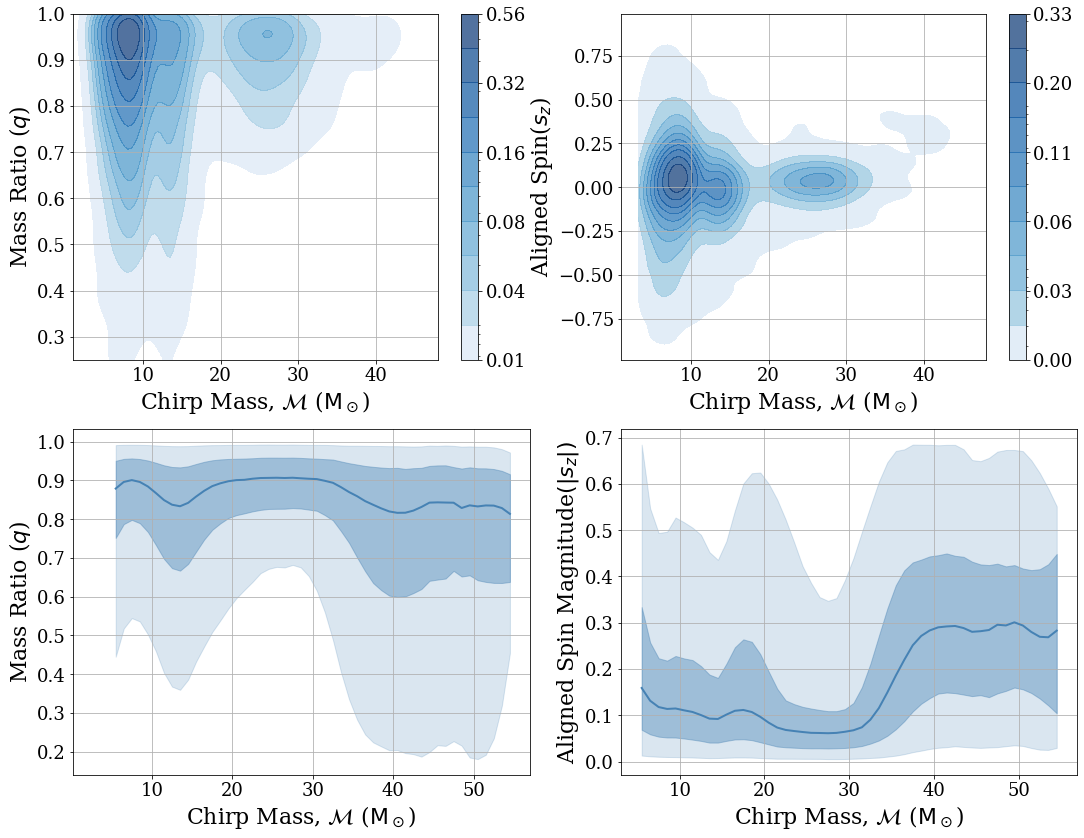

In [13]:
fig = plt.figure(figsize = (18.0, 7.0 * 2))
plt.subplot(2, 2, 1)
levels = np.linspace(0.05, 1, 11)
seaborn.kdeplot(x=ppdmch[::nperkde], y=ppdq[::nperkde], cmap="Blues", alpha = 0.7,\
        shade=True, cbar=True, levels = levels, norm=LogNorm(), cbar_kws = {'format': '%2.2f'})
plt.grid()
plt.xlabel('Chirp Mass, $\mathcal{M}$ ($\mathrm{M}_\odot$)', fontsize=22)
plt.ylabel('Mass Ratio ($q$)', fontsize=22)
plt.ylim(0.25, 1.0)
plt.xlim(1, 48.)
plt.subplot(2, 2, 2)
seaborn.kdeplot(x=ppdmch[::nperkde], y=ppdsz[::nperkde], cmap="Blues", alpha = 0.7,\
        shade=True, cut = 0, cbar=True, levels = levels, norm=LogNorm(), cbar_kws = {'format': '%2.2f'})
plt.grid()
plt.xlabel('Chirp Mass, $\mathcal{M}$ ($\mathrm{M}_\odot$)', fontsize=22)
plt.ylabel('Aligned Spin($s_z$)', fontsize=22)
plt.xlim(1, 48.)
plt.subplot(2, 2, 3)
ax = 0.5 * (mchax[1:] + mchax[:-1])
plt.plot(ax, savgol_filter(p50_mch_q, 9, 3), color = 'steelblue', linewidth = 2.0)
plt.fill_between(ax, savgol_filter(p25_mch_q, 9, 3), savgol_filter(p75_mch_q, 9, 3), alpha = 0.4, color = 'steelblue')
plt.fill_between(ax, savgol_filter(p5_mch_q, 9, 3), savgol_filter(p95_mch_q, 9, 3), alpha = 0.2, color = 'steelblue')
plt.grid()
plt.xlabel('Chirp Mass, $\mathcal{M}$ ($\mathrm{M}_\odot$)', fontsize=22)
plt.ylabel('Mass Ratio ($q$)', fontsize=22)
plt.xlim(.2, None)
plt.subplot(2, 2, 4)
plt.plot(ax, savgol_filter(p50_mch_sz, 9, 3), color = 'steelblue', linewidth = 2.0)
plt.fill_between(ax, savgol_filter(p25_mch_sz, 9, 3), savgol_filter(p75_mch_sz, 9, 3), alpha = 0.4, color = 'steelblue')
plt.fill_between(ax, savgol_filter(p5_mch_sz, 9, 3), savgol_filter(p95_mch_sz, 9, 3), alpha = 0.2, color = 'steelblue')
plt.grid()
plt.xlabel('Chirp Mass, $\mathcal{M}$ ($\mathrm{M}_\odot$)', fontsize=22)
plt.ylabel('Aligned Spin Magnitude$(|s_z|)$', fontsize=22)
plt.savefig(directory + '/mchirp_q_sz.jpg', dpi = 200, bbox_inches = 'tight')

In [14]:
#90% Confidence Intervals
print ('Rate')
p5, p50, p95 = np.percentile(rate, 5.), np.mean(rate), np.percentile(rate, 95.)
print (np.round(p5, 2), '-' ,np.round(p95, 2))
print (np.round(p50, 2), '+',np.round(p95 - p50, 2), '-',np.round(p50 - p5, 2))
#Post o3a LIGO rate: 
lp5, lp95, lp50 = 15.3, 38.8, 23.9
lp50 = 0.5 * (lp5 + lp95)
print ('Masses')
masses = np.append(ppd_m1, ppd_m2)
p1, p99 = np.percentile(masses, 1.), np.percentile(masses, 99.)
print (np.round(np.percentile(masses[masses > p99], 5.), 2), np.round(np.percentile(masses[masses > p99], 95.), 2))
print (np.round(np.percentile(masses[masses < p1], 5.), 2), np.round(np.percentile(masses[masses < p1], 95.), 2))
print ('Mass - ratio:', np.round(np.percentile(ppd_q, 10.), 2), np.round(len(ppd_q) / 1./len(ppd_q[ppd_q < 1/1.9 ** 2]), 2))
print ('Other stuff')
print (np.round(np.percentile(ppd_s1z, 5.), 2), np.round(np.percentile(ppd_s1z, 95.), 2))

Rate
14.92 - 35.62
23.84 + 11.78 - 8.93
Masses
52.74 135.25
2.85 4.85
Mass - ratio: 0.61 0.16
Other stuff
-0.39 0.37


### Plots with confidence interval

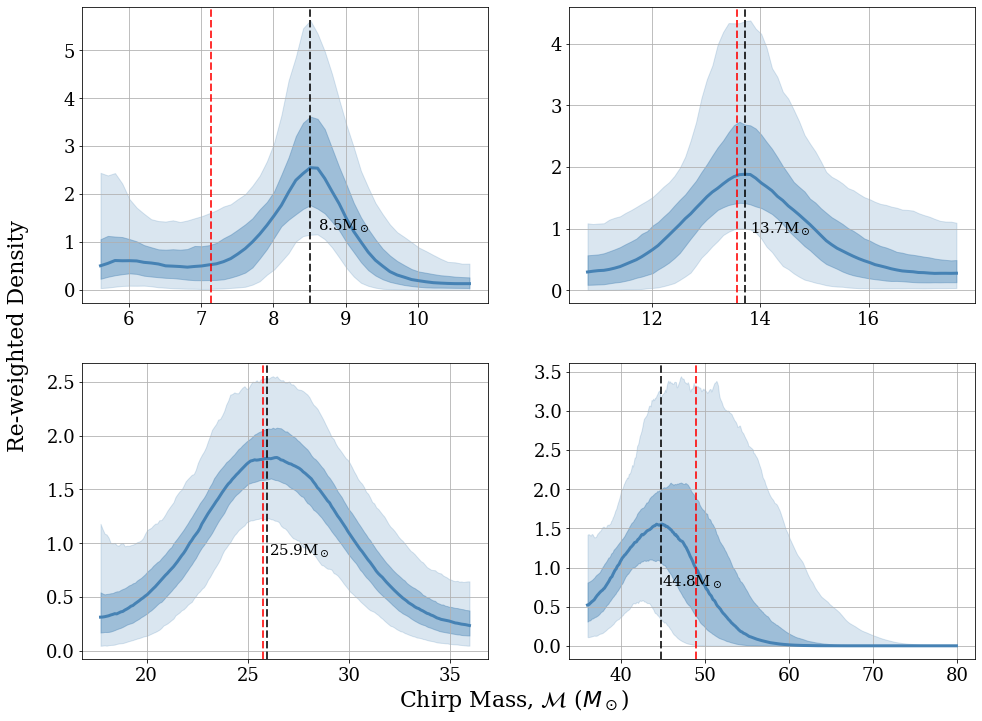

In [15]:
xg1 = 8.2/2**0.2#7.4
p0, p1 = 0.04827, 0.01707
p2 = p1/4
breaks = np.array([5.6, 10.8, 17.7, 36., 80.])
fig = plt.figure(figsize = (16.0, 12.0))
gloc, gloc_meanval = [], []
perc_kept = 0.95
for ii in range(len(breaks) - 1):
    idx = np.where((ppd_mch > breaks[ii]) & (ppd_mch < breaks[ii + 1]))
    data = ppd_mch[idx]

    plt.subplot(2, 2, ii + 1)
    maxllkl = -np.inf
    for aa in np.arange(0.15, 9.15, .1):
        llkl = np.sum(np.log(models.powerlaw_pdf(data, breaks[ii], breaks[ii + 1], aa)))
        if llkl > maxllkl:
            alfa = aa
            maxllkl = llkl
    idx_mchaxsel = np.where((mch_ax > breaks[ii]) & (mch_ax < breaks[ii + 1]))
    mchaxsel = mch_ax[idx_mchaxsel]
    ratios, meanpeakg = [], []
    for pdf in post_pdfs_mch:
        truncpdf = pdf[idx_mchaxsel]
        nrm = np.sum(truncpdf) * (mch_ax[1] - mch_ax[0])
        truncpdf /= nrm
        ratios.append(truncpdf / models.powerlaw_pdf(mch_ax[idx_mchaxsel], breaks[ii], breaks[ii + 1], alfa))
    
    ratios_ll90 = np.percentile(np.array(ratios), 5., axis = 0)
    ratios_ul90 = np.percentile(np.array(ratios), 95., axis = 0)
    ratios_ll50 = np.percentile(np.array(ratios), 25., axis = 0)
    ratios_ul50 = np.percentile(np.array(ratios), 75., axis = 0)
    mean_ratios = np.percentile(np.array(ratios), 50., axis = 0)
    

    plt.plot(mch_ax[idx_mchaxsel], mean_ratios, linewidth = 3.0, color = 'steelblue')
    plt.fill_between(mch_ax[idx_mchaxsel], ratios_ll90, ratios_ul90, alpha = 0.2, color = 'steelblue')
    plt.fill_between(mch_ax[idx_mchaxsel], ratios_ll50, ratios_ul50, alpha = 0.4, color = 'steelblue')
    gloc.append(mch_ax[idx_mchaxsel][np.argmax(savgol_filter(mean_ratios, 39, 5))])
    plt.axvline(x = gloc[-1], color = 'black', linestyle = '--', alpha = 0.8, linewidth = 2.0)
    plt.axvline(x = xg1 * (perc_kept * 2) ** ii, color = 'red', linestyle = '--', alpha = 0.8, linewidth = 2.0)
    plt.text(gloc[-1] +.1, np.max(mean_ratios)/2, str(np.round(gloc[-1], 1)) + 'M$_\odot$')
    plt.grid()
    
fig.text(0.06, 0.5, 'Re-weighted Density', va='center', fontsize=22, rotation='vertical')
fig.text(0.5, 0.07, 'Chirp Mass, $\mathcal{M}$ ($M_\odot$)', ha='center', fontsize=22)
plt.savefig(directory + '/normalised_peaks_wng13.jpg', dpi = dpi, bbox_inches = 'tight')

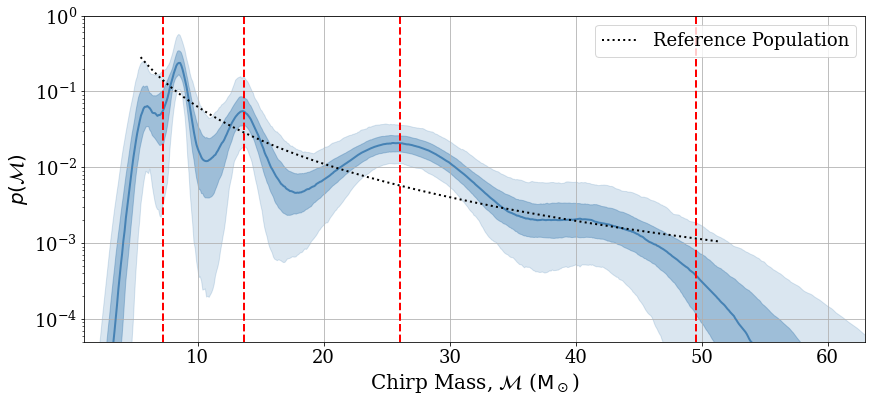

In [16]:
mch_ul90 = np.percentile(np.array(post_pdfs_mch), 5., axis = 0)
mch_ll90 = np.percentile(np.array(post_pdfs_mch), 95., axis = 0)
mch_ul50 = np.percentile(np.array(post_pdfs_mch), 25., axis = 0)
mch_ll50 = np.percentile(np.array(post_pdfs_mch), 75., axis = 0)
mean_mch_pdf = np.percentile(np.array(post_pdfs_mch), 50., axis = 0)

axmch = 0.5 * (results['args_sampler']['ref_mch_samp'][1:] + results['args_sampler']['ref_mch_samp'][:-1])
daxmch = np.diff(results['args_sampler']['ref_mch_samp'])
fig = plt.figure(figsize = (14.0, 6.0))
plt.plot(mch_ax, mean_mch_pdf, color = 'steelblue', linewidth = 2.)
plt.fill_between(mch_ax, mch_ul90, mch_ll90, alpha = 0.2, color = 'steelblue')
plt.fill_between(mch_ax, mch_ul50, mch_ll50, alpha = 0.4, color = 'steelblue')
xg1 = gloc[1]/1.9
perc_kept = 0.95
xg2 = xg1 * 2 * perc_kept
xg3 = xg2 * 2 * perc_kept
xg4 = xg3 * 2 * perc_kept

plt.axvline(x = xg1, color = 'red', linestyle = '--', linewidth = 2.0)
plt.axvline(x = xg2, color = 'red', linestyle = '--', linewidth = 2.0)
plt.axvline(x = xg3, color = 'red', linestyle = '--', linewidth = 2.0)
plt.axvline(x = xg4, color = 'red', linestyle = '--', linewidth = 2.0)
plt.xlabel('Chirp Mass, $\mathcal{M}$ ($\mathrm{M}_\odot$)', fontsize=20)
plt.plot(axmch, results['args_sampler']['ref_mch_prob']/daxmch, label = 'Reference Population', color ='black',linestyle=':', linewidth = 2.0)
plt.ylabel('$p(\mathcal{M})$', fontsize=20)
plt.xlim(1, 63.)
plt.ylim(5e-5, 1.)
plt.yscale('log')
plt.grid()
plt.legend(loc = 'best')
plt.savefig(directory + '/confidence_mchirp.jpg', dpi = dpi, bbox_inches = 'tight')

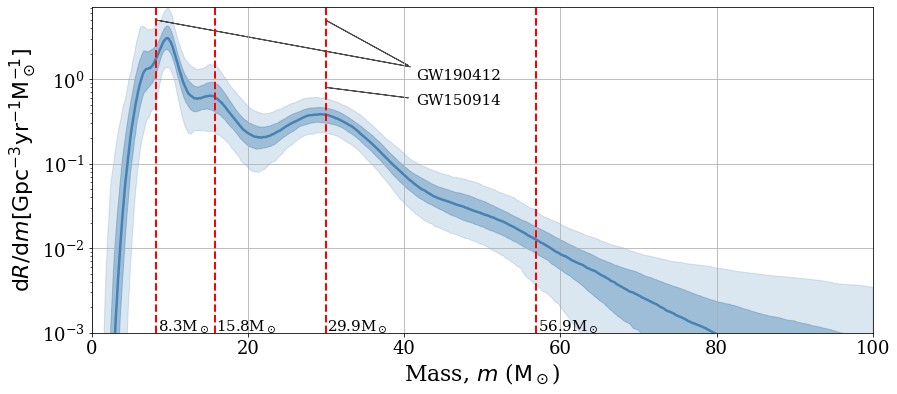

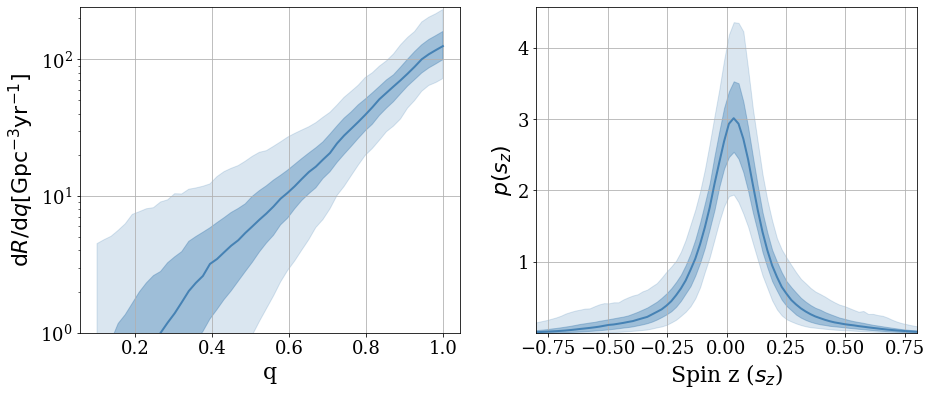

In [17]:
fig = plt.figure(figsize = (14.0, 6.0))
m1dr_ll90 = np.percentile(rate * np.array(post_pdfs_mass).T, 5., axis = 1)
m1dr_ul90 = np.percentile(rate * np.array(post_pdfs_mass).T, 95., axis = 1)
m1dr_ll50 = np.percentile(rate * np.array(post_pdfs_mass).T, 25., axis = 1)
m1dr_ul50 = np.percentile(rate * np.array(post_pdfs_mass).T, 75., axis = 1)
mean_m_dr = np.percentile(rate * np.array(post_pdfs_mass).T, 50., axis = 1)

plt.plot(mass_ax, mean_m_dr, color = 'steelblue', linewidth = 2.5)
plt.fill_between(mass_ax, m1dr_ll90, m1dr_ul90, alpha = 0.2, color = 'steelblue')
plt.fill_between(mass_ax, m1dr_ll50, m1dr_ul50, alpha = 0.4, color = 'steelblue')

details = True

if details:
    xg1 = 2 ** 0.2 * gloc[1]/1.9
    perc_kept = 0.95
    xg2 = xg1 * 2 * perc_kept
    xg3 = xg2 * 2 * perc_kept
    xg4, xg5 = xg3 * 2 * perc_kept, 75

    plt.axvline(x = xg1, color = 'red', linestyle = '--', linewidth = 2.0)
    plt.axvline(x = xg2, color = 'red', linestyle = '--', linewidth = 2.0)
    plt.axvline(x = xg3, color = 'red', linestyle = '--', linewidth = 2.0)
    plt.axvline(x = xg4, color = 'red', linestyle = '--', linewidth = 2.0)
    #plt.axvline(x = xg5, color = 'black', linestyle = 'dotted', alpha = 0.7, linewidth = 2.0)

    plt.text(xg1 + 0.2, 0.0011, str(np.round(xg1, 1)) + 'M$_\odot$')
    plt.text(xg2 + 0.2, 0.0011, str(np.round(xg2, 1)) + 'M$_\odot$')
    plt.text(xg3 + 0.2, 0.0011, str(np.round(xg3, 1)) + 'M$_\odot$')
    plt.text(xg4 + 0.2, 0.0011, str(np.round(xg4, 1)) + 'M$_\odot$')
    plt.arrow(xg3, 0.8, 10.6, -.2, alpha = 0.7)
    plt.text(41.5, 0.5, 'GW150914')
    #plt.text(xg5 - 10.6, 1.0, 'GW190521')
    plt.arrow(xg1, 5.0, 32.5, -3.6, alpha = 0.7)
    plt.arrow(xg3, 5.0, 10.6, -3.55, alpha = 0.7)
    plt.text(41.5, 1.0, 'GW190412')

plt.xlabel('Mass, $m$ ($\mathrm{M}_\odot$)', fontsize=22)
plt.ylabel('$\mathrm{d}R/\mathrm{d}m[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}\mathrm{M}_\odot^{-1}]$', fontsize=22)
plt.xlim(0., 100.)
plt.ylim(1e-3, None)
plt.yscale('log')
plt.grid()
plt.savefig(directory + '/confidence_mass.jpg', dpi = dpi, bbox_inches = 'tight')

fig = plt.figure(figsize = (15.0, 6.0))
plt.subplot(1, 2, 1)
q_ll90 = np.percentile(rate * np.array(post_pdfs_q).T, 5., axis = 1)
q_ul90 = np.percentile(rate * np.array(post_pdfs_q).T, 95., axis = 1)
q_ll50 = np.percentile(rate * np.array(post_pdfs_q).T, 25., axis = 1)
q_ul50 = np.percentile(rate * np.array(post_pdfs_q).T, 75., axis = 1)
mean_q_pdf = np.percentile(rate * np.array(post_pdfs_q).T, 50., axis = 1)
plt.plot(q_ax, mean_q_pdf, color = 'steelblue', linewidth = 2.0)
plt.fill_between(q_ax, q_ll90, q_ul90, alpha = 0.2, color = 'steelblue')
plt.fill_between(q_ax, q_ll50, q_ul50, alpha = 0.4, color = 'steelblue')
plt.grid()
plt.ylim(1., None)
plt.yscale('log')
plt.xlabel('q', fontsize=22)
plt.ylabel('$\mathrm{d}R/\mathrm{d}q[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}]$', fontsize=22)
plt.subplot(1, 2, 2)
sz_ll90 = np.percentile(np.array(post_pdfs_sz).T, 5., axis = 1)
sz_ul90 = np.percentile(np.array(post_pdfs_sz).T, 95., axis = 1)
sz_ll50 = np.percentile(np.array(post_pdfs_sz).T, 25., axis = 1)
sz_ul50 = np.percentile(np.array(post_pdfs_sz).T, 75., axis = 1)
mean_sz_pdf = np.percentile(np.array(post_pdfs_sz).T, 50., axis = 1)
plt.plot(sz_ax, mean_sz_pdf, color = 'steelblue', linewidth = 2.0)
plt.fill_between(sz_ax, sz_ll90, sz_ul90, alpha = 0.2, color = 'steelblue')
plt.fill_between(sz_ax, sz_ll50, sz_ul50, alpha = 0.4, color = 'steelblue')
plt.grid()
plt.ylim(2e-3, None)
plt.xlim(-0.8, 0.8)
plt.xlabel('Spin z ($s_z$)', fontsize=22)
plt.ylabel('$p(s_z)$', fontsize=22)

plt.savefig(directory + '/confidence_q_sz.jpg', dpi = dpi, bbox_inches = 'tight')